In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_curve 
from numpy import loadtxt
#from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
#importing training dataset (2668)
T_data = pd.read_excel("Training.xlsx")

#Importing validation dataset (523)
V_data = pd.read_excel("Validation.xlsx")

print("training data {}. ".format(T_data.shape))
print("validation data {}. ".format(V_data.shape))

training data (2669, 63). 
validation data (523, 63). 


In [3]:
developing_data = T_data.copy()
validation_data = V_data.copy()

In [4]:
developing_data.rename(columns={'30_days_Mortality':"mortality",'pre_Beta_blocker':"Pre-treatment (beta-blockers)",
                                'MR_mild':'mild MR','LAD_0_1':'TIMI flow grade 0-1 in LAD','RCA_0_1':'TIMI flow grade 0-1 in RCA'
                                ,'RCA_2_3':'TIMI flow grade 2-3 in RCA','EF_>50Percent': 'LVEF >50%',
                                'Physical_Activity':'Physical Activity','EF_31-40Percent':"LVEF 31-40%",
                                'Sex_1e0ale':"Female Sex",'initial_creatinine_val':"Serum Creatinine", 
                                'PCI_1t_done':'Medical therapy without PCI','Age_group':"Age < 40 years",'EF_<30Percent':'LVEF<30%',
                               'LAD_2_3':'TIMI flow grade 2-3 in LAD', 'CardiacStatus_Presentation_HF':'Heart Failure at presentation ',
                               'Presentation_Cardiogenic shock ':'Cardiogenic Shock at presentation',
                                'Delay_To_Hospital':"Delayed Presentation",
                                'pre_ACE_ARB':"Pre-treatment (ACEi/ARBs)",'Smoking_Pack_year':"Smokimg (pack-year)",
                                'MR_Moderate-Severe':"Moderate-severe MR",
                                'PCI_Timing <=12 hours':"PCI performed within 12 hours",
                                  'initial_hb_value':'Hemoglobin','pre_Diabetes_Mellitus':'Diabetes Mellitus',
                                'initial_hg_baic':'HbA1C',
                                'EF_41-49Percent':'LVEF 41-49%','pre_Hypertension':'Hypertension'},inplace=True)
validation_data.rename(columns={'30_days_Mortality':"mortality",'pre_Beta_blocker':"Pre-treatment (beta-blockers)",
                                'MR_mild':'mild MR','LAD_0_1':'TIMI flow grade 0-1 in LAD','RCA_0_1':'TIMI flow grade 0-1 in RCA'
                                ,'RCA_2_3':'TIMI flow grade 2-3 in RCA','EF_>50Percent': 'LVEF >50%',
                                'EF_31-40Percent':"LVEF 31-40%",
                                'Sex_1e0ale':"Female Sex",'initial_creatinine_val':"Serum Creatinine", 
                                'PCI_1t_done':'Medical therapy without PCI','Age_group':"Age < 40 years",'EF_<30Percent':'LVEF<30%',
                               'LAD_2_3':'TIMI flow grade 2-3 in LAD', 'CardiacStatus_Presentation_HF':'Heart Failure at presentation ',
                               'Presentation_Cardiogenic shock ':'Cardiogenic Shock at presentation',
                                'Delay_To_Hospital':"Delayed Presentation",'Physical_Activity':'Physical Activity',
                                'pre_ACE_ARB':"Pre-treatment (ACEi/ARBs)",'Smoking_Pack_year':"Smokimg (pack-year)",
                                'MR_Moderate-Severe':"Moderate-severe MR",
                                'PCI_Timing <=12 hours':"PCI performed within 12 hours",
                                  'initial_hb_value':'Hemoglobin','pre_Diabetes_Mellitus':'Diabetes Mellitus',
                                'initial_hg_baic':'HbA1C',
                                'EF_41-49Percent':'LVEF 41-49%','pre_Hypertension':'Hypertension'},inplace=True)

developing_data = developing_data.drop(['patient_UID', 'pre_CVA',"Age < 40 years" ,
       'pre_Hyperlipidemia', 'pre_ASPIRIN', 'pre_STATIN','mild MR','Anticoagulant_UFH',
       'pre_Anticoagulant', 'Patient/Relative unwillingness','PCI_Timing>72hours','Shortness of breath',
       'Transient resolution of Sx', 'Misinterpretation of Sx', 'DAPT_therapy',  'AtH_Anticoagulant_LMWH',
], axis=1)

#'EF_31-40Percent', 'PCI_Timing>72hours','Pre_PCI_TIMI_Grade','Inferior Wall MI', 'Lateral Wall MI' 'LAD_angiography', 
#'LCX_Angiography', 'LMCA_angiography', 'RCA_angiography',
validation_data = validation_data.drop(['patient_UID', 'pre_CVA', "Age < 40 years",
       'pre_Hyperlipidemia', 'pre_ASPIRIN', 'pre_STATIN','mild MR','Anticoagulant_UFH',
       'pre_Anticoagulant', 'Patient/Relative unwillingness','PCI_Timing>72hours','Shortness of breath',
       'Transient resolution of Sx', 'Misinterpretation of Sx', 'DAPT_therapy',  'AtH_Anticoagulant_LMWH',
 ], axis=1)

In [5]:
neg, pos = np.bincount(developing_data['mortality'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 2669
    Positive: 206 (7.72% of total)



In [6]:
developing_data = developing_data.drop(['Pre_PCI_TIMI_Grade','pre_P2Y12_Inhibitors','total occusion','AtH_Tirofiban',
                                        'pre_Atrial_fib_flutter','pre_HeartFailure','Time_to_1st_ECG >6hours',
                                       'pre_INSULIN','Pre_PCI_TIMI_Grade','LAD_angiography', 'LCX_Angiography',
                                        'LMCA_angiography','RCA_angiography', 'SCAD_angiography',
                                        ], axis=1)

#'EF_31-40Percent', 'PCI_Timing>72hours'
validation_data = validation_data.drop(['Pre_PCI_TIMI_Grade','pre_P2Y12_Inhibitors','total occusion','AtH_Tirofiban',
                                        'pre_Atrial_fib_flutter','pre_HeartFailure','Time_to_1st_ECG >6hours',
                                       'pre_INSULIN','Pre_PCI_TIMI_Grade','LAD_angiography', 'LCX_Angiography',
                                        'LMCA_angiography','RCA_angiography', 'SCAD_angiography',
                                         ], axis=1)

In [7]:
dev_majority = developing_data[developing_data.mortality==0]
dev_minority = developing_data[developing_data.mortality==1]


dev_majority_unsampled = resample(dev_majority,
                                 replace=True,
                                 n_samples = 1330,
                               random_state =18)

dev_minority_unsampled = resample(dev_minority,
                                 replace=True,
                                 n_samples = 1330,
                                 random_state =18)

dev_unsample =pd.concat([dev_majority_unsampled,dev_minority_unsampled])

dev_unsample.shape

(2660, 34)

In [8]:
scaler = MinMaxScaler()

dev_unsample[['Age','Smokimg (pack-year)','Serum Creatinine', 'Hemoglobin', 'HbA1C']] = scaler.fit_transform(dev_unsample[
                                                                                ['Age','Smokimg (pack-year)','Serum Creatinine',
                                                                                 'Hemoglobin', 'HbA1C']])

validation_data[['Age','Smokimg (pack-year)','Serum Creatinine', 'Hemoglobin', 'HbA1C']] = scaler.transform(validation_data[
                                                                                    ['Age','Smokimg (pack-year)','Serum Creatinine',
                                                                                    'Hemoglobin', 'HbA1C']])

In [9]:
X_features = dev_unsample.drop(labels=['mortality'], axis=1)
y_labels = dev_unsample['mortality']

X_unseen = validation_data.drop(labels=['mortality'], axis=1)
y_unseen = validation_data['mortality']

#splitting the training data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.4, random_state=1)

## Extra Tree 

In [104]:
# Building the model
#extra_tree_forest = ExtraTreesClassifier()
extra_tree_forest = ExtraTreesClassifier(n_estimators=150,
    criterion="entropy",
    max_depth=6,
    min_samples_split=4,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=False,
    oob_score=False,
    random_state=1,
    verbose=0,
    class_weight={0: 1, 1: 1.4},
    warm_start=False,
    ccp_alpha=0.001,
    max_samples=None,)

# Training the model
extra_tree_forest.fit(X_train, y_train)
preds = extra_tree_forest.predict(X_test)

print()
print("Extra Tree Model: classification report training data")
print()
print(classification_report(y_test, preds))
acc = accuracy_score(y_test, preds)
print()
print("Accuracy is: " + str(acc))
print(confusion_matrix(y_test, preds))
print()

TN, FP, FN, TP = confusion_matrix(y_test, preds).ravel()

sensitivity  = TP / (TP+FN)
specificity  = TN / (TN+FP)

print("Sensitivity {}. ".format(sensitivity))
print("specificity {}. ".format(specificity))

AUC_LG = roc_auc_score(y_test, extra_tree_forest.predict(X_test))*100
AUC_LG = "{:.1f}".format(AUC_LG)
AUC_LG =str(AUC_LG)+"%"
print(AUC_LG)


Extra Tree Model: classification report training data

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       517
           1       0.78      0.87      0.82       547

    accuracy                           0.80      1064
   macro avg       0.81      0.80      0.80      1064
weighted avg       0.81      0.80      0.80      1064


Accuracy is: 0.8045112781954887
[[380 137]
 [ 71 476]]

Sensitivity 0.870201096892139. 
specificity 0.7350096711798839. 
80.3%


In [105]:
preds = extra_tree_forest.predict(X_unseen)

print()
print("Extra Tree Model: classification report validation data")
print()
print(classification_report(y_unseen, preds))
acc = accuracy_score(y_unseen, preds)
print()
print("Accuracy is: " + str(acc))
print(confusion_matrix(y_unseen, preds))
print()

TN, FP, FN, TP = confusion_matrix(y_unseen, preds).ravel()

sensitivity  = TP / (TP+FN)
specificity  = TN / (TN+FP)

print("Sensitivity {}. ".format(sensitivity))
print("specificity {}. ".format(specificity))

AUC_LG = roc_auc_score(y_unseen, extra_tree_forest.predict(X_unseen))*100
AUC_LG = "{:.1f}".format(AUC_LG)
AUC_LG =str(AUC_LG)+"%"
print(AUC_LG)


Extra Tree Model: classification report validation data

              precision    recall  f1-score   support

           0       0.98      0.74      0.85       483
           1       0.22      0.85      0.34        40

    accuracy                           0.75       523
   macro avg       0.60      0.80      0.60       523
weighted avg       0.92      0.75      0.81       523


Accuracy is: 0.751434034416826
[[359 124]
 [  6  34]]

Sensitivity 0.85. 
specificity 0.7432712215320911. 
79.7%


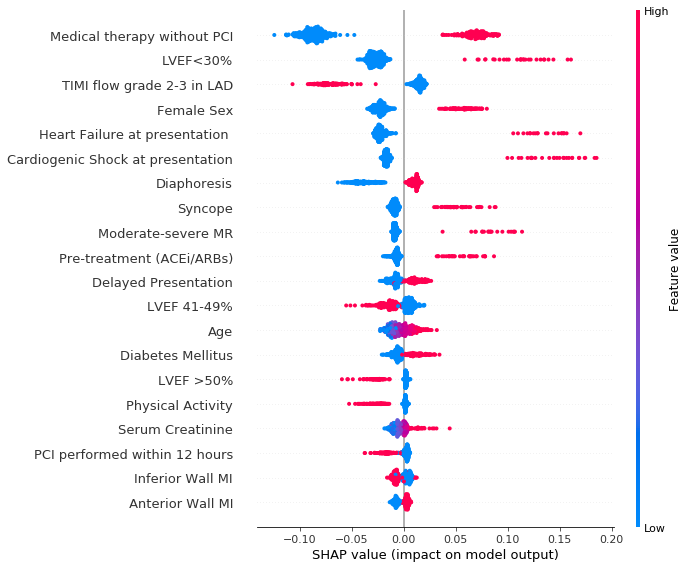

In [108]:
explainer = shap.TreeExplainer(extra_tree_forest)
shap_values = explainer.shap_values(X_unseen)
sv = np.array(shap_values)
y = extra_tree_forest.predict(X_unseen).astype("bool")
# shap values for survival
sv_survive = sv[:,y,:]
# shap values for dying
sv_die = sv[:,~y,:]

shap.summary_plot(shap_values[1], X_unseen.astype("float"))

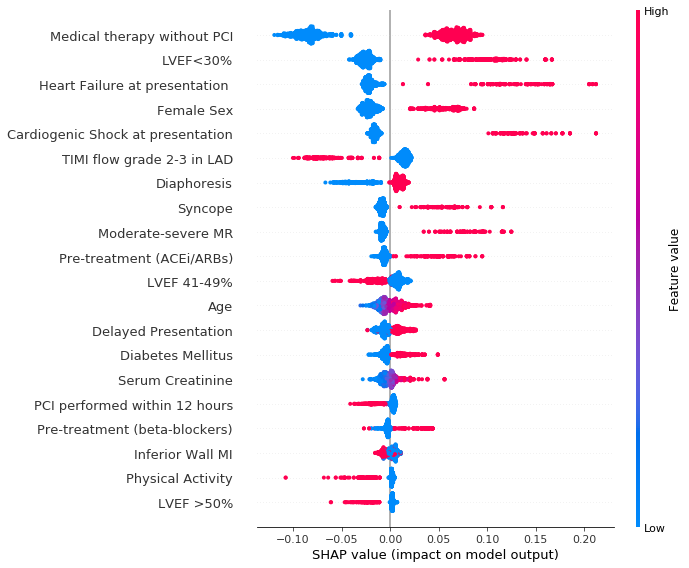

In [106]:
explainer = shap.TreeExplainer(extra_tree_forest)
shap_values = explainer.shap_values(X_train)
sv = np.array(shap_values)
y = extra_tree_forest.predict(X_train).astype("bool")
# shap values for survival
sv_survive = sv[:,y,:]
# shap values for dying
sv_die = sv[:,~y,:]

shap.summary_plot(shap_values[1], X_train.astype("float"))

In [48]:
extra_tree_forest = loaded_model

In [10]:
import pickle
# save the model to disk
filename = 'ET_Feb18_2022.sav'
#pickle.dump(RF_clf, open(filename, 'wb'))

#load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [42]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(360,),max_iter=1000,activation = 'relu',
                           alpha=0.001,
                           learning_rate_init=0.001,
                           solver='sgd',random_state=1)

classifier.fit(X_train, y_train) 
rf_pred = classifier.predict(X_test)

print(classification_report(y_test, rf_pred))
acc = accuracy_score(y_test, rf_pred)
print()
print("Accuracy is: " + str(acc))
print(confusion_matrix(y_test, rf_pred))
print()

TN, FP, FN, TP = confusion_matrix(y_test, rf_pred).ravel()

sensitivity  = TP / (TP+FN)
specificity  = TN / (TN+FP)

print("Sensitivity {}. ".format(sensitivity))
print("specificity {}. ".format(specificity))

AUC_MP = roc_auc_score(y_test, classifier.predict(X_test))*100
AUC_MP = "{:.1f}".format(AUC_MP)
AUC_MP =str(AUC_MP)+"%"
print(AUC_MP)

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       517
           1       0.84      0.74      0.78       547

    accuracy                           0.79      1064
   macro avg       0.79      0.79      0.79      1064
weighted avg       0.80      0.79      0.79      1064


Accuracy is: 0.7913533834586466
[[437  80]
 [142 405]]

Sensitivity 0.7404021937842779. 
specificity 0.8452611218568665. 
79.3%


In [43]:
rf_pred = classifier.predict(X_unseen)

print("Neural Network classification report on validation set")
print()
print(classification_report(y_unseen, rf_pred))
acc = accuracy_score(y_unseen, rf_pred)
print()
print("Accuracy is: " + str(acc))
print(confusion_matrix(y_unseen, rf_pred))
print()

TN, FP, FN, TP = confusion_matrix(y_unseen, rf_pred).ravel()

sensitivity  = TP / (TP+FN)
specificity  = TN / (TN+FP)

print("Sensitivity {}. ".format(sensitivity))
print("specificity {}. ".format(specificity))

AUC_LG = roc_auc_score(y_unseen, classifier.predict(X_unseen))*100
AUC_LG = "{:.1f}".format(AUC_LG)
AUC_LG =str(AUC_LG)+"%"
print(AUC_LG)

Neural Network classification report on validation set

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       483
           1       0.27      0.62      0.37        40

    accuracy                           0.84       523
   macro avg       0.62      0.74      0.64       523
weighted avg       0.91      0.84      0.87       523


Accuracy is: 0.8393881453154876
[[414  69]
 [ 15  25]]

Sensitivity 0.625. 
specificity 0.8571428571428571. 
74.1%


In [51]:
import pickle
# save the model to disk
filename = 'MP_Apr1_2022.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [25]:
RF_clf = RandomForestClassifier(n_estimators=150,
    criterion='gini',
    max_depth=8,
    min_samples_split=3,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    random_state=0,
    min_impurity_decrease=0.0,
    class_weight={0: 1, 1:1.1},
    oob_score=False,
    n_jobs=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.001,
    max_samples=None)

RF_clf.fit(X_train, y_train) 
rf_pred = RF_clf.predict(X_test)

print(classification_report(y_test, rf_pred))
acc = accuracy_score(y_test, rf_pred)
print()
print("Accuracy is: " + str(acc))
print(confusion_matrix(y_test, rf_pred))
print()

TN, FP, FN, TP = confusion_matrix(y_test, rf_pred).ravel()

sensitivity  = TP / (TP+FN)
specificity  = TN / (TN+FP)

print("Sensitivity {}. ".format(sensitivity))
print("specificity {}. ".format(specificity))

AUC_RF = roc_auc_score(y_test, RF_clf.predict(X_test))*100
AUC_RF = "{:.1f}".format(AUC_RF)
AUC_RF =str(AUC_RF)+"%"
print(AUC_RF)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       517
           1       0.89      0.88      0.88       547

    accuracy                           0.88      1064
   macro avg       0.88      0.88      0.88      1064
weighted avg       0.88      0.88      0.88      1064


Accuracy is: 0.8806390977443609
[[458  59]
 [ 68 479]]

Sensitivity 0.8756855575868373. 
specificity 0.8858800773694391. 
88.1%


In [26]:
rf_pred = RF_clf.predict(X_unseen)

print("Random Forest classification report on validation set")
print()
print(classification_report(y_unseen, rf_pred))
acc = accuracy_score(y_unseen, rf_pred)
print()
print("Accuracy is: " + str(acc))
print(confusion_matrix(y_unseen, rf_pred))
print()

TN, FP, FN, TP = confusion_matrix(y_unseen, rf_pred).ravel()

sensitivity  = TP / (TP+FN)
specificity  = TN / (TN+FP)

print("Sensitivity {}. ".format(sensitivity))
print("specificity {}. ".format(specificity))

AUC_LG = roc_auc_score(y_unseen, RF_clf.predict(X_unseen))*100
AUC_LG = "{:.1f}".format(AUC_LG)
AUC_LG =str(AUC_LG)+"%"
print(AUC_LG)

Random Forest classification report on validation set

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       483
           1       0.29      0.62      0.40        40

    accuracy                           0.86       523
   macro avg       0.63      0.75      0.66       523
weighted avg       0.91      0.86      0.88       523


Accuracy is: 0.8565965583173997
[[423  60]
 [ 15  25]]

Sensitivity 0.625. 
specificity 0.8757763975155279. 
75.0%


In [52]:
import pickle
# save the model to disk
filename = 'RF_Apr1_2022.sav'
pickle.dump(RF_clf, open(filename, 'wb'))

In [46]:
LogReg_clf = LogisticRegression(penalty='l2',C=2,solver='lbfgs')
#LogReg_clf = LogisticRegression()
LogReg_clf.fit(X_train, y_train)
LogReg_pred = LogReg_clf.predict(X_test)

print(classification_report(y_test, LogReg_pred))
acc = accuracy_score(y_test, LogReg_pred)
print()
print("Accuracy is: " + str(acc))
print(confusion_matrix(y_test, LogReg_pred))
print()

TN, FP, FN, TP = confusion_matrix(y_test, LogReg_pred).ravel()

sensitivity  = TP / (TP+FN)
specificity  = TN / (TN+FP)

print("Sensitivity {}. ".format(sensitivity))
print("specificity {}. ".format(specificity))

print("AUC {}.".format(roc_auc_score(y_test, LogReg_clf.predict(X_test))))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       517
           1       0.84      0.75      0.79       547

    accuracy                           0.80      1064
   macro avg       0.80      0.80      0.80      1064
weighted avg       0.80      0.80      0.80      1064


Accuracy is: 0.7960526315789473
[[439  78]
 [139 408]]

Sensitivity 0.7458866544789763. 
specificity 0.8491295938104448. 
AUC 0.7975081241447106.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [47]:
LogReg_preds = LogReg_clf.predict(X_unseen)
print(classification_report(y_unseen, LogReg_preds))
acc = accuracy_score(y_unseen, LogReg_preds)
print()
print("Accuracy is: " + str(acc))
print(confusion_matrix(y_unseen, LogReg_preds))
print()

TN, FP, FN, TP = confusion_matrix(y_unseen, LogReg_preds).ravel()

sensitivity  = TP / (TP+FN)
specificity  = TN / (TN+FP)

print("Sensitivity {}. ".format(sensitivity))
print("specificity {}. ".format(specificity))
print("AUC {}.".format(roc_auc_score(y_unseen, LogReg_clf.predict(X_unseen))))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       483
           1       0.23      0.57      0.33        40

    accuracy                           0.82       523
   macro avg       0.59      0.71      0.61       523
weighted avg       0.90      0.82      0.85       523


Accuracy is: 0.8202676864244742
[[406  77]
 [ 17  23]]

Sensitivity 0.575. 
specificity 0.8405797101449275. 
AUC 0.7077898550724636.


In [53]:
import pickle
# save the model to disk
filename = 'LG_Apr1_2022.sav'
pickle.dump(LogReg_clf, open(filename, 'wb'))

In [39]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
#model_CBC = CatBoostClassifier()
model_CBC = CatBoostClassifier(iterations=100, learning_rate=0.01,class_weights = (1, 1),depth=4,
                                    l2_leaf_reg=5,
                                    model_size_reg=None,
                                    rsm=None,
                                    loss_function='Logloss')

model_CBC.fit(X_train, y_train)
print(model_CBC)

0:	learn: 0.6903152	total: 9.69ms	remaining: 959ms
1:	learn: 0.6877872	total: 14.3ms	remaining: 702ms
2:	learn: 0.6844534	total: 19.1ms	remaining: 617ms
3:	learn: 0.6817383	total: 23.7ms	remaining: 570ms
4:	learn: 0.6787477	total: 32.6ms	remaining: 619ms
5:	learn: 0.6760499	total: 37.6ms	remaining: 589ms
6:	learn: 0.6733092	total: 42.3ms	remaining: 562ms
7:	learn: 0.6703436	total: 50ms	remaining: 575ms
8:	learn: 0.6677481	total: 53.8ms	remaining: 544ms
9:	learn: 0.6652240	total: 58.4ms	remaining: 526ms
10:	learn: 0.6627480	total: 62.9ms	remaining: 509ms
11:	learn: 0.6605763	total: 67.5ms	remaining: 495ms
12:	learn: 0.6584186	total: 72.1ms	remaining: 482ms
13:	learn: 0.6558746	total: 76.7ms	remaining: 471ms
14:	learn: 0.6533582	total: 83.4ms	remaining: 473ms
15:	learn: 0.6508058	total: 87.9ms	remaining: 461ms
16:	learn: 0.6484647	total: 92.6ms	remaining: 452ms
17:	learn: 0.6464932	total: 97.8ms	remaining: 445ms
18:	learn: 0.6441959	total: 102ms	remaining: 437ms
19:	learn: 0.6421077	tota

In [40]:
expected_y  = y_test
predicted_y = model_CBC.predict(X_test)

print("Catboost classification report on traininng set")
print()
print(classification_report(expected_y, predicted_y))
acc = accuracy_score(expected_y, predicted_y)
print()
print("Accuracy is: " + str(acc))
print(confusion_matrix(expected_y, predicted_y))
print()

TN, FP, FN, TP = confusion_matrix(expected_y, predicted_y).ravel()

sensitivity  = TP / (TP+FN)
specificity  = TN / (TN+FP)

print("Sensitivity {}. ".format(sensitivity))
print("specificity {}. ".format(specificity))

print("AUC {}.".format(roc_auc_score(y_test, model_CBC.predict(X_test))))

Catboost classification report on traininng set

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       517
           1       0.80      0.74      0.77       547

    accuracy                           0.77      1064
   macro avg       0.77      0.77      0.77      1064
weighted avg       0.77      0.77      0.77      1064


Accuracy is: 0.7716165413533834
[[416 101]
 [142 405]]

Sensitivity 0.7404021937842779. 
specificity 0.804642166344294. 
AUC 0.7725221800642859.


In [41]:
expected_y  = y_unseen
predicted_y = model_CBC.predict(X_unseen)

print("Catboost classification report on traininng set")
print()
print(classification_report(expected_y, predicted_y))
acc = accuracy_score(expected_y, predicted_y)
print()
print("Accuracy is: " + str(acc))
print(confusion_matrix(expected_y, predicted_y))
print()

TN, FP, FN, TP = confusion_matrix(expected_y, predicted_y).ravel()

sensitivity  = TP / (TP+FN)
specificity  = TN / (TN+FP)

print("Sensitivity {}. ".format(sensitivity))
print("specificity {}. ".format(specificity))

print("AUC {}.".format(roc_auc_score(y_unseen, model_CBC.predict(X_unseen))))

Catboost classification report on traininng set

              precision    recall  f1-score   support

           0       0.98      0.81      0.88       483
           1       0.25      0.75      0.37        40

    accuracy                           0.80       523
   macro avg       0.61      0.78      0.63       523
weighted avg       0.92      0.80      0.85       523


Accuracy is: 0.8049713193116634
[[391  92]
 [ 10  30]]

Sensitivity 0.75. 
specificity 0.8095238095238095. 
AUC 0.7797619047619048.


In [54]:
import pickle
# save the model to disk
filename = 'CAT_Apr1_2022.sav'
pickle.dump(model_CBC, open(filename, 'wb'))

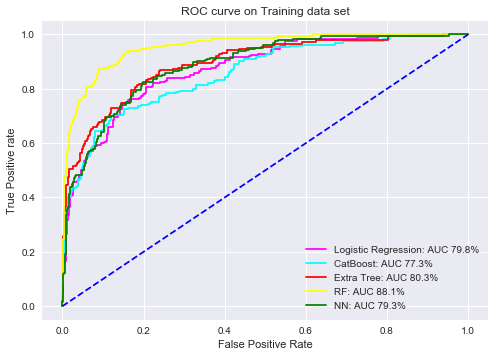

In [49]:
pred_prob1 = LogReg_clf.predict_proba(X_test)
pred_prob2 = model_CBC.predict_proba(X_test)
pred_prob3 = extra_tree_forest.predict_proba(X_test)
pred_prob4 = RF_clf.predict_proba(X_test)
#pred_prob5 = bnb.predict_proba(X_test)
pred_prob6 = classifier.predict_proba(X_test)
#pred_prob7 = voting_clf.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)
#fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob5[:,1], pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(y_test, pred_prob6[:,1], pos_label=1)
#fpr7, tpr7, thresh7 = roc_curve(y_test, pred_prob7[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

AUC_LG = roc_auc_score(y_test, LogReg_clf.predict(X_test))*100
AUC_LG = "{:.1f}".format(AUC_LG)
AUC_LG =str(AUC_LG)+"%"

AUC_CT = roc_auc_score(y_test, model_CBC.predict(X_test))*100
AUC_CT = "{:.1f}".format(AUC_CT)
AUC_CT =str(AUC_CT)+"%"

AUC_Vote = roc_auc_score(y_test, extra_tree_forest.predict(X_test))*100
AUC_Vote = "{:.1f}".format(AUC_Vote)
AUC_Vote =str(AUC_Vote)+"%"

AUC_RF = roc_auc_score(y_test, RF_clf.predict(X_test))*100
AUC_RF = "{:.1f}".format(AUC_RF)
AUC_RF =str(AUC_RF)+"%"

#AUC_bnb = roc_auc_score(y_test, bnb.predict(X_test))*100
#AUC_bnb = "{:.1f}".format(AUC_bnb)
#AUC_bnb =str(AUC_bnb)+"%"

AUC_DT = roc_auc_score(y_test, classifier.predict(X_test))*100
AUC_DT = "{:.1f}".format(AUC_DT)
AUC_DT =str(AUC_DT)+"%"

#AUC_MP = roc_auc_score(y_test, voting_clf.predict(X_test))*100
#AUC_MP = "{:.1f}".format(AUC_MP)
#AUC_MP =str(AUC_MP)+"%"

plt.style.use('seaborn')
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='-',color='magenta', label='Logistic Regression: AUC ' +AUC_LG)
plt.plot(fpr2, tpr2, linestyle='-',color='cyan', label='CatBoost: AUC '+ AUC_CT)
plt.plot(fpr3, tpr3, linestyle='-',color='red', label='Extra Tree: AUC '+ AUC_Vote)
plt.plot(fpr4, tpr4, linestyle='-',color='yellow', label='RF: AUC '+AUC_RF)
#plt.plot(fpr5, tpr5, linestyle=':',color='blue', label='BurnoliNB: AUC '+AUC_bnb)
plt.plot(fpr6, tpr6, linestyle='-',color='green', label='NN: AUC '+AUC_DT)
#plt.plot(fpr7, tpr7, linestyle='-',color='magenta', label='Vote: AUC '+AUC_MP)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve on Training data set')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

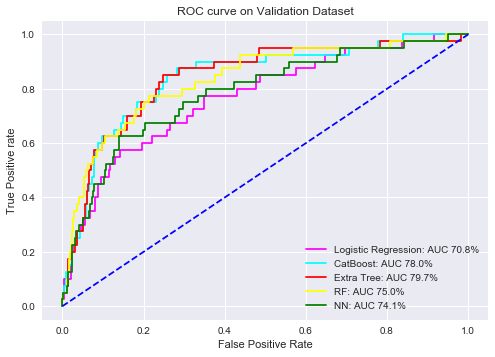

In [50]:
pred_prob1 = LogReg_clf.predict_proba(X_unseen)
pred_prob2 = model_CBC.predict_proba(X_unseen)
pred_prob3 = extra_tree_forest.predict_proba(X_unseen)
pred_prob4 = RF_clf.predict_proba(X_unseen)
#pred_prob5 = bnb.predict_proba(X_unseen)
pred_prob6 = classifier.predict_proba(X_unseen)
#pred_prob7 = voting_clf.predict_proba(X_unseen)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_unseen, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_unseen, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_unseen, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_unseen, pred_prob4[:,1], pos_label=1)
#fpr5, tpr5, thresh5 = roc_curve(y_unseen, pred_prob5[:,1], pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(y_unseen, pred_prob6[:,1], pos_label=1)
#fpr7, tpr7, thresh7 = roc_curve(y_unseen, pred_prob7[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_unseen))]
p_fpr, p_tpr, _ = roc_curve(y_unseen, random_probs, pos_label=1)

AUC_LG = roc_auc_score(y_unseen, LogReg_clf.predict(X_unseen))*100
AUC_LG = "{:.1f}".format(AUC_LG)
AUC_LG =str(AUC_LG)+"%"

AUC_NB = roc_auc_score(y_unseen, model_CBC.predict(X_unseen))*100
AUC_NB = "{:.1f}".format(AUC_NB)
AUC_NB =str(AUC_NB)+"%"

AUC_ET = roc_auc_score(y_unseen, extra_tree_forest.predict(X_unseen))*100
AUC_ET = "{:.1f}".format(AUC_ET)
AUC_ET =str(AUC_ET)+"%"

AUC_RF = roc_auc_score(y_unseen, RF_clf.predict(X_unseen))*100
AUC_RF = "{:.1f}".format(AUC_RF)
AUC_RF =str(AUC_RF)+"%"

#AUC_bnb = roc_auc_score(y_unseen, bnb.predict(X_unseen))*100
#AUC_bnb = "{:.1f}".format(AUC_bnb)
#AUC_bnb =str(AUC_bnb)+"%"

AUC_DT = roc_auc_score(y_unseen, classifier.predict(X_unseen))*100
AUC_DT = "{:.1f}".format(AUC_DT)
AUC_DT =str(AUC_DT)+"%"

#AUC_MP = roc_auc_score(y_unseen, voting_clf.predict(X_unseen))*100
#AUC_MP = "{:.1f}".format(AUC_MP)
#AUC_MP =str(AUC_MP)+"%"


plt.style.use('seaborn')
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='-',color='magenta', label='Logistic Regression: AUC ' +AUC_LG)
plt.plot(fpr2, tpr2, linestyle='-',color='cyan', label='CatBoost: AUC '+ AUC_NB)
plt.plot(fpr3, tpr3, linestyle='-',color='red', label='Extra Tree: AUC '+ AUC_ET)
plt.plot(fpr4, tpr4, linestyle='-',color='yellow', label='RF: AUC '+AUC_RF)
#plt.plot(fpr5, tpr5, linestyle='-',color='blue', label='BurnoliNB: AUC '+AUC_bnb)
plt.plot(fpr6, tpr6, linestyle='-',color='green', label='NN: AUC '+AUC_DT)
#plt.plot(fpr7, tpr7, linestyle='-',color='magenta', label='Vote: AUC '+AUC_MP)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve on Validation Dataset')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();